In [1]:
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from scipy.spatial.distance import pdist
from shapely.geometry import Point
from pyproj import Transformer
import os
from scipy.interpolate import griddata
from scipy.interpolate import LinearNDInterpolator

### create grid

In [ ]:
sensors_CO=pd.read_csv('/path/to/sensors_CO.csv')
sensors_CO

,Unnamed: 0,idsensore,nometiposensore,unitamisura,idstazione,nomestazione,quota,provincia,comune,storico,datastart,utm_nord,utm_est,lat,lng,location,datastop
0,0,5814,Monossido di Carbonio,mg/m³,551,Arconate v. De Gasperi,182,MI,Arconate,N,1999-01-20T00:00:00.000,5043898,488082,45.548521,8.847327,"{'type': 'Point', 'coordinates': [8.84732669, ...",NaN
1,3,5835,Monossido di Carbonio,mg/m³,504,Sesto San Giovanni v. Cesare da Sesto,139,MI,Sesto San Giovanni,N,1990-04-29T00:00:00.000,5042386,518435,45.534768,9.236109,"{'type': 'Point', 'coordinates': [9.23610903, ...",NaN
2,6,5834,Monossido di Carbonio,mg/m³,548,Milano v.Senato,118,MI,Milano,N,1995-05-01T00:00:00.000,5035238,515435,45.470501,9.197461,"{'type': 'Point', 'coordinates': [9.19746075, ...",NaN
3,7,5812,Monossido di Carbonio,mg/m³,606,San Giuliano Milanese via Milano,97,MI,San Giuliano Milanese,N,2000-01-13T00:00:00.000,5027003,522127,45.396198,9.282699,"{'type': 'Point', 'coordinates': [9.28269897, ...",NaN
4,17,5827,Monossido di Carbonio,mg/m³,501,Milano v.Marche,129,MI,Milano,N,1989-04-05T00:00:00.000,5038105,514918,45.496319,9.190934,"{'type': 'Point', 'coordinates': [9.19093444, ...",NaN


In [3]:
sensors_CO = sensors_CO[['idsensore', 'utm_nord', 'utm_est']].copy()
# Create Point geometries directly from utm_nord and utm_est columns
sensors_CO['geometry'] = sensors_CO.apply(lambda row: Point(row['utm_est'], row['utm_nord']), axis=1)

# Convert the pandas DataFrame to a GeoDataFrame
sensors_CO = gpd.GeoDataFrame(sensors_CO, geometry='geometry')

# Set the CRS to EPSG:32632 (UTM zone 32N)
sensors_CO.set_crs(epsg=32632, inplace=True)
sensors_CO

,idsensore,utm_nord,utm_est,geometry
0,5814,5043898,488082,POINT (488082 5043898)
1,5835,5042386,518435,POINT (518435 5042386)
2,5834,5035238,515435,POINT (515435 5035238)
3,5812,5027003,522127,POINT (522127 5027003)
4,5827,5038105,514918,POINT (514918 5038105)


In [ ]:
milano=gpd.read_file("/path/to/MCM_wgs84.shp")

In [5]:
milano = milano.to_crs(epsg=32632)  # Convert to EPSG:32632
print(milano.crs)

EPSG:32632


<Axes: >

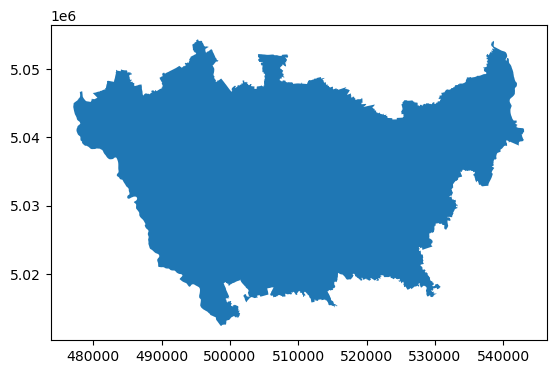

In [6]:
milano.plot()

In [7]:
milano.bounds

,minx,miny,maxx,maxy
0,477060.0205,5.012389e+06,543075.5321,5.054348e+06


In [8]:
# Get bounds of Milano
minx, miny, maxx, maxy = milano.total_bounds

In [9]:
# Get UTM coordinates of sensors
utm_coords = sensors_CO[["utm_est", "utm_nord"]].values

# Calculate pairwise distances (in meters)
distances = pdist(utm_coords)
resolution = np.min(distances[distances > 0])  # Minimum non-zero distance
print(resolution)


2913.2418368546064


In [10]:
#resolution=1000 you can use other resolution

In [11]:
# Generate easting (x) and northing (y) ranges
easting = np.arange(minx, maxx + resolution, resolution)
northing = np.arange(miny, maxy + resolution, resolution)

# Create grid points
grid_easting, grid_northing = np.meshgrid(easting, northing)
grid_points = np.vstack([grid_easting.ravel(), grid_northing.ravel()]).T

# Convert to GeoDataFrame
grid_gdf = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(grid_points[:, 0], grid_points[:, 1]),
    crs="EPSG:32632"
)

In [12]:
# Build a tree for the grid
tree = cKDTree(grid_points)

# Query sensor UTM coordinates
sensor_coords = sensors_CO[["utm_est", "utm_nord"]].values
_, nearest_indices = tree.query(sensor_coords, k=1)

# Assign grid IDs to sensors
sensors_CO["grid_id"] = nearest_indices

In [13]:
# Add grid geometry to sensors
grid_gdf = grid_gdf.reset_index().rename(columns={"index": "grid_id"})
grid_gdf

,grid_id,geometry
0,0,POINT (477060.02 5012388.661)
1,1,POINT (479973.262 5012388.661)
2,2,POINT (482886.504 5012388.661)
3,3,POINT (485799.746 5012388.661)
4,4,POINT (488712.988 5012388.661)
...,...,...
379,379,POINT (532411.615 5056087.288)
380,380,POINT (535324.857 5056087.288)
381,381,POINT (538238.099 5056087.288)
382,382,POINT (541151.341 5056087.288)


In [14]:
sensor_grid=grid_gdf.merge(
        sensors_CO,
        on="grid_id", 
        how="left", 
        suffixes=("_grid", "_sensore")
)

In [15]:
sensor_grid

,grid_id,geometry_grid,idsensore,utm_nord,utm_est,geometry_sensore
0,0,POINT (477060.02 5012388.661),NaN,NaN,NaN,None
1,1,POINT (479973.262 5012388.661),NaN,NaN,NaN,None
2,2,POINT (482886.504 5012388.661),NaN,NaN,NaN,None
3,3,POINT (485799.746 5012388.661),NaN,NaN,NaN,None
4,4,POINT (488712.988 5012388.661),NaN,NaN,NaN,None
...,...,...,...,...,...,...
379,379,POINT (532411.615 5056087.288),NaN,NaN,NaN,None
380,380,POINT (535324.857 5056087.288),NaN,NaN,NaN,None
381,381,POINT (538238.099 5056087.288),NaN,NaN,NaN,None
382,382,POINT (541151.341 5056087.288),NaN,NaN,NaN,None


In [16]:
sensor_grid[~sensor_grid['idsensore'].isnull()]

,grid_id,geometry_grid,idsensore,utm_nord,utm_est,geometry_sensore
135,135,POINT (520758.648 5026954.87),5812.0,5027003.0,522127.0,POINT (522127 5027003)
205,205,POINT (514932.164 5035694.595),5834.0,5035238.0,515435.0,POINT (515435 5035238)
229,229,POINT (514932.164 5038607.837),5827.0,5038105.0,514918.0,POINT (514918 5038105)
254,254,POINT (517845.406 5041521.079),5835.0,5042386.0,518435.0,POINT (518435 5042386)
268,268,POINT (488712.988 5044434.321),5814.0,5043898.0,488082.0,POINT (488082 5043898)


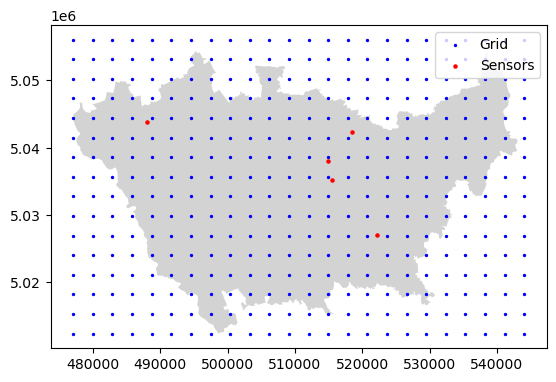

In [17]:
fig, ax = plt.subplots()
milano.plot(ax=ax, color="lightgrey")
grid_gdf.plot(ax=ax, markersize=2, color="blue", label="Grid")
sensors_CO.plot(ax=ax, color="red", markersize=5, label="Sensors")
plt.legend()
plt.show()

### read data

In [ ]:
arpa_df=pd.read_csv('/path/to/arpa_mean_21_15.csv')
arpa_df

,Unnamed: 0,date,idsensore,valore
0,0,2019-01-01,5812,0.618750
1,1,2019-01-01,5814,1.243750
2,2,2019-01-01,5827,1.400000
3,3,2019-01-01,5834,1.812500
4,4,2019-01-01,5835,0.825000
...,...,...,...,...
10608,10608,2025-01-01,5812,1.100000
10609,10609,2025-01-01,5814,1.433333
10610,10610,2025-01-01,5827,2.833333
10611,10611,2025-01-01,5834,1.066667


In [19]:
arpa_df = arpa_df.drop(columns=['Unnamed: 0'])
arpa_df['date'] = pd.to_datetime(arpa_df['date'], errors='coerce')
arpa_df=arpa_df.merge(sensor_grid,on='idsensore',how='inner')
arpa_df

,date,idsensore,valore,grid_id,geometry_grid,utm_nord,utm_est,geometry_sensore
0,2019-01-01,5812,0.618750,135,POINT (520758.648 5026954.87),5027003.0,522127.0,POINT (522127 5027003)
1,2019-01-01,5814,1.243750,268,POINT (488712.988 5044434.321),5043898.0,488082.0,POINT (488082 5043898)
2,2019-01-01,5827,1.400000,229,POINT (514932.164 5038607.837),5038105.0,514918.0,POINT (514918 5038105)
3,2019-01-01,5834,1.812500,205,POINT (514932.164 5035694.595),5035238.0,515435.0,POINT (515435 5035238)
4,2019-01-01,5835,0.825000,254,POINT (517845.406 5041521.079),5042386.0,518435.0,POINT (518435 5042386)
...,...,...,...,...,...,...,...,...
10608,2025-01-01,5812,1.100000,135,POINT (520758.648 5026954.87),5027003.0,522127.0,POINT (522127 5027003)
10609,2025-01-01,5814,1.433333,268,POINT (488712.988 5044434.321),5043898.0,488082.0,POINT (488082 5043898)
10610,2025-01-01,5827,2.833333,229,POINT (514932.164 5038607.837),5038105.0,514918.0,POINT (514918 5038105)
10611,2025-01-01,5834,1.066667,205,POINT (514932.164 5035694.595),5035238.0,515435.0,POINT (515435 5035238)


In [20]:
s5p_df=pd.read_feather('s5p_CO.feather')
s5p_df = s5p_df.drop(columns=['spatial_ref'])
s5p_df.rename(columns={'band':'date'},inplace=True)
s5p_df['date'] = pd.to_datetime(s5p_df['date'], errors='coerce')
s5p_df

,date,y,x,s5p_CO
0,2019-01-01,45.745209,8.605039,0.033858
1,2019-01-01,45.745209,8.615039,0.033858
2,2019-01-01,45.745209,8.625039,0.033858
3,2019-01-01,45.745209,8.635039,0.033941
4,2019-01-01,45.745209,8.645040,0.033974
...,...,...,...,...
13708763,2024-12-31,45.165207,9.615044,0.038014
13708764,2024-12-31,45.165207,9.625044,0.038014
13708765,2024-12-31,45.165207,9.635044,0.038011
13708766,2024-12-31,45.165207,9.645044,0.037952


In [ ]:
era5_df=pd.read_feather('/path/to/era5_21_15.feather')
era5_df.rename(columns={'latitude':'y','longitude':'x'},inplace=True)
era5_df['date'] = pd.to_datetime(era5_df['date'], errors='coerce')
era5_df

,date,y,x,lai_hv,lai_lv,tp,ssr,str,t2m,sp,...,lai_hv_pre,lai_lv_pre,tp_pre,ssr_pre,str_pre,t2m_pre,sp_pre,blh_pre,wind_speed_pre,wind_dir_pre
24,2019-01-03,45.20,8.40,2.643202,1.427744,0.0,285686.718750,-313340.25000,275.765472,100370.640625,...,2.643370,1.428233,0.0,112481.085938,-323692.34375,278.762024,100102.710938,397.693604,3.874868,37.474537
25,2019-01-03,45.20,8.65,2.811998,1.066452,0.0,282271.562500,-324308.09375,276.204681,101083.140625,...,2.812035,1.066570,0.0,109820.484375,-346585.34375,279.780823,100806.414062,601.149841,5.636369,43.492329
26,2019-01-03,45.20,8.90,2.609673,1.026146,0.0,278746.031250,-344442.84375,277.352631,101421.281250,...,2.609673,1.026146,0.0,107327.289062,-371359.75000,281.286469,101177.265625,836.218628,6.558743,41.681988
27,2019-01-03,45.20,9.15,2.132586,1.363134,0.0,276096.875000,-356013.46875,277.280914,101167.570312,...,2.132658,1.363158,0.0,105215.687500,-382719.34375,281.256104,100976.609375,1013.343567,5.652373,29.174677
28,2019-01-03,45.20,9.40,1.891854,1.646348,0.0,273715.187500,-359793.93750,276.925049,101308.898438,...,1.891905,1.646361,0.0,102873.890625,-384806.56250,280.732574,101149.765625,1044.837280,4.689242,216.157028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52291,2024-12-31,45.95,8.65,1.874295,2.607710,0.0,269023.375000,-290412.46875,276.826172,95368.281250,...,1.874511,2.607811,0.0,94851.617188,-292192.81250,280.518585,95233.640625,18.170195,0.686395,107.751663
52292,2024-12-31,45.95,8.90,1.759272,2.467265,0.0,272558.000000,-285352.68750,277.569366,95612.562500,...,1.759954,2.467601,0.0,94434.218750,-284695.81250,280.309265,95476.890625,19.260258,0.735813,49.314262
52293,2024-12-31,45.95,9.15,1.789009,2.323392,0.0,272288.218750,-285625.53125,277.102478,94132.296875,...,1.789879,2.323912,0.0,92451.015625,-285925.40625,279.459534,94006.835938,19.322735,0.774533,43.526237
52294,2024-12-31,45.95,9.40,2.059782,2.217351,0.0,259572.296875,-276817.84375,275.714203,92664.570312,...,2.060454,2.217796,0.0,87140.820312,-282449.40625,277.984558,92549.085938,17.572269,0.939204,32.815205


In [ ]:
cams=pd.read_feather('/path/to/CAMS_21_15.feather')
cams['date'] = pd.to_datetime(cams['date'], errors='coerce')
cams

,date,latitude,longitude,cams_CO,r,r_pre
0,2019-01-01,45.00,8.00,3.742165e-07,NaN,NaN
1,2019-01-01,45.00,8.75,5.875754e-07,NaN,NaN
2,2019-01-01,45.00,9.50,5.860836e-07,NaN,NaN
3,2019-01-01,45.00,10.25,5.013875e-07,NaN,NaN
4,2019-01-01,45.75,8.00,2.419757e-07,NaN,NaN
...,...,...,...,...,...,...
17291,2024-12-01,45.00,10.25,2.855481e-07,NaN,NaN
17292,2024-12-01,45.75,8.00,2.987221e-07,NaN,NaN
17293,2024-12-01,45.75,8.75,2.783389e-07,NaN,NaN
17294,2024-12-01,45.75,9.50,2.893257e-07,NaN,NaN


In [23]:
cams.dtypes

date         datetime64[ns]
latitude            float64
longitude           float64
cams_CO             float32
r                   float32
r_pre               float32
dtype: object

### reference system transform

In [24]:
# Initialize transformer for S5P and ERA5
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32632", always_xy=True)

# S5P data
s5p_df['utm_est'], s5p_df['utm_nord'] = transformer.transform(
    s5p_df['x'].values, s5p_df['y'].values
)

# ERA5 data
era5_df['utm_est'], era5_df['utm_nord'] = transformer.transform(
    era5_df['x'].values, era5_df['y'].values
)
#cams data
cams['utm_est'], cams['utm_nord'] = transformer.transform(
    cams['longitude'].values, cams['latitude'].values
)

In [25]:
s5p_df

,date,y,x,s5p_CO,utm_est,utm_nord
0,2019-01-01,45.745209,8.605039,0.033858,469277.219863,5.065815e+06
1,2019-01-01,45.745209,8.615039,0.033858,470055.092548,5.065811e+06
2,2019-01-01,45.745209,8.625039,0.033858,470832.965256,5.065807e+06
3,2019-01-01,45.745209,8.635039,0.033941,471610.837985,5.065804e+06
4,2019-01-01,45.745209,8.645040,0.033974,472388.710736,5.065800e+06
...,...,...,...,...,...,...
13708763,2024-12-31,45.165207,9.615044,0.038014,548335.364213,5.001487e+06
13708764,2024-12-31,45.165207,9.625044,0.038014,549121.252359,5.001493e+06
13708765,2024-12-31,45.165207,9.635044,0.038011,549907.140499,5.001499e+06
13708766,2024-12-31,45.165207,9.645044,0.037952,550693.028632,5.001505e+06


In [26]:
era5_df

,date,y,x,lai_hv,lai_lv,tp,ssr,str,t2m,sp,...,tp_pre,ssr_pre,str_pre,t2m_pre,sp_pre,blh_pre,wind_speed_pre,wind_dir_pre,utm_est,utm_nord
24,2019-01-03,45.20,8.40,2.643202,1.427744,0.0,285686.718750,-313340.25000,275.765472,100370.640625,...,0.0,112481.085938,-323692.34375,278.762024,100102.710938,397.693604,3.874868,37.474537,452875.632473,5.005343e+06
25,2019-01-03,45.20,8.65,2.811998,1.066452,0.0,282271.562500,-324308.09375,276.204681,101083.140625,...,0.0,109820.484375,-346585.34375,279.780823,100806.414062,601.149841,5.636369,43.492329,472510.783839,5.005228e+06
26,2019-01-03,45.20,8.90,2.609673,1.026146,0.0,278746.031250,-344442.84375,277.352631,101421.281250,...,0.0,107327.289062,-371359.75000,281.286469,101177.265625,836.218628,6.558743,41.681988,492145.938001,5.005173e+06
27,2019-01-03,45.20,9.15,2.132586,1.363134,0.0,276096.875000,-356013.46875,277.280914,101167.570312,...,0.0,105215.687500,-382719.34375,281.256104,100976.609375,1013.343567,5.652373,29.174677,511781.092959,5.005179e+06
28,2019-01-03,45.20,9.40,1.891854,1.646348,0.0,273715.187500,-359793.93750,276.925049,101308.898438,...,0.0,102873.890625,-384806.56250,280.732574,101149.765625,1044.837280,4.689242,216.157028,531416.246722,5.005246e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52291,2024-12-31,45.95,8.65,1.874295,2.607710,0.0,269023.375000,-290412.46875,276.826172,95368.281250,...,0.0,94851.617188,-292192.81250,280.518585,95233.640625,18.170195,0.686395,107.751663,472874.294631,5.088552e+06
52292,2024-12-31,45.95,8.90,1.759272,2.467265,0.0,272558.000000,-285352.68750,277.569366,95612.562500,...,0.0,94434.218750,-284695.81250,280.309265,95476.890625,19.260258,0.735813,49.314262,492249.797068,5.088497e+06
52293,2024-12-31,45.95,9.15,1.789009,2.323392,0.0,272288.218750,-285625.53125,277.102478,94132.296875,...,0.0,92451.015625,-285925.40625,279.459534,94006.835938,19.322735,0.774533,43.526237,511625.304165,5.088503e+06
52294,2024-12-31,45.95,9.40,2.059782,2.217351,0.0,259572.296875,-276817.84375,275.714203,92664.570312,...,0.0,87140.820312,-282449.40625,277.984558,92549.085938,17.572269,0.939204,32.815205,531000.804271,5.088570e+06


In [27]:
cams

,date,latitude,longitude,cams_CO,r,r_pre,utm_est,utm_nord
0,2019-01-01,45.00,8.00,3.742165e-07,NaN,NaN,421184.697083,4.983437e+06
1,2019-01-01,45.00,8.75,5.875754e-07,NaN,NaN,480296.175805,4.982981e+06
2,2019-01-01,45.00,9.50,5.860836e-07,NaN,NaN,539407.649017,4.983072e+06
3,2019-01-01,45.00,10.25,5.013875e-07,NaN,NaN,598519.133053,4.983710e+06
4,2019-01-01,45.75,8.00,2.419757e-07,NaN,NaN,422219.794494,5.066758e+06
...,...,...,...,...,...,...,...,...
17291,2024-12-01,45.00,10.25,2.855481e-07,NaN,NaN,598519.133053,4.983710e+06
17292,2024-12-01,45.75,8.00,2.987221e-07,NaN,NaN,422219.794494,5.066758e+06
17293,2024-12-01,45.75,8.75,2.783389e-07,NaN,NaN,480554.925829,5.066302e+06
17294,2024-12-01,45.75,9.50,2.893257e-07,NaN,NaN,538890.139238,5.066393e+06


In [28]:
# Extract easting (x) and northing (y) from grid geometry
grid_gdf['utm_est'] = grid_gdf.geometry.x
grid_gdf['utm_nord'] = grid_gdf.geometry.y
grid_points = grid_gdf[["utm_est", "utm_nord"]].values

### s5p

In [29]:
#nearest 
def interpolate_s5p(date_subset, grid_points):
    if date_subset.empty:
        return np.full(grid_points.shape[0], np.nan)
    
    coords = date_subset[["utm_est", "utm_nord"]].values
    values = date_subset["s5p_CO"].values
    tree = cKDTree(coords)
    
    # Query with 7km radius and k=1 neighbor
    distances, indices = tree.query(grid_points, k=1, distance_upper_bound=7000)
    
    # Mask for valid neighbors (within 7km)
    valid_mask = indices < len(values)
    
    # Assign values where valid
    interpolated = np.full(grid_points.shape[0], np.nan)
    interpolated[valid_mask] = values[indices[valid_mask]]
    
    return interpolated


### era5

In [30]:
# Get ERA5 variable names
era5_vars = ['tp', 'ssr', 'str', 't2m', 'sp', 'blh',
              'wind_speed','wind_dir','lai_hv','lai_lv',
              'tp_pre', 'ssr_pre', 'str_pre', 't2m_pre', 'sp_pre', 'blh_pre',
              'wind_speed_pre','wind_dir_pre','lai_hv_pre','lai_lv_pre']


In [31]:
def interpolate_era5(date_subset, grid_points):
    if date_subset.empty or len(date_subset) < 3:
        return {var: np.full(len(grid_points), np.nan) for var in era5_vars}
    
    era5_points = date_subset[["utm_est", "utm_nord"]].values
    era5_values = np.column_stack([date_subset[var] for var in era5_vars])  # Shape: (n_points, n_vars)
    
    interpolator = LinearNDInterpolator(era5_points, era5_values)
    interpolated_values = interpolator(grid_points)  # Shape: (n_grid_points, n_vars)
    
    # Split into variables
    return {
        var: interpolated_values[:, i] 
        for i, var in enumerate(era5_vars)
    }

### cams

In [32]:
cams_vars=['cams_CO','r','r_pre']

In [33]:
def interpolate_cams(date_subset, grid_points):
    if date_subset.empty or len(date_subset) < 3:
        return {var: np.full(grid_points.shape[0], np.nan) for var in cams_vars}
    
    cams_coords = date_subset[["utm_est", "utm_nord"]].values
    cams_values = {var: date_subset[var].values for var in cams_vars}
    
    interpolated = {}
    for var in cams_vars:
        interpolator = LinearNDInterpolator(cams_coords, cams_values[var])
        interpolated[var] = interpolator(grid_points)
    
    return interpolated


In [ ]:
# Prepare output file
output_path = "/path/to/interpolated_results.csv"
if not os.path.exists(output_path):
    pd.DataFrame(columns=["date", "grid_id", "s5p_CO"] + cams_vars + era5_vars).to_csv(output_path, index=False)

# Process dates
for date in pd.date_range(start='2019-01-01', end='2024-12-31'):
    print(f"Processing {date.date()}")
    
    # Interpolate S5P
    s5p_subset = s5p_df[s5p_df['date'] == date]
    s5p_interp = interpolate_s5p(s5p_subset, grid_points)
    
    # Interpolate cams
    cams_subset = cams[cams['date'] == date]
    cams_interp = interpolate_cams(cams_subset, grid_points)

    # Interpolate ERA5
    era5_subset = era5_df[era5_df['date'] == date]
    era5_interp = interpolate_era5(era5_subset, grid_points)  
    
    # Create DataFrame chunk
    chunk = pd.DataFrame({
        "date": date,
        "grid_id": grid_gdf["grid_id"],
        "s5p_CO": s5p_interp,
        **cams_interp,
        **era5_interp
    })
    
    # Append to CSV
    chunk.to_csv(output_path, mode='a', header=False, index=False)

Processing 2019-01-01
Processing 2019-01-02
Processing 2019-01-03
Processing 2019-01-04
Processing 2019-01-05
Processing 2019-01-06
Processing 2019-01-07
Processing 2019-01-08
Processing 2019-01-09
Processing 2019-01-10
Processing 2019-01-11
Processing 2019-01-12
Processing 2019-01-13
Processing 2019-01-14
Processing 2019-01-15
Processing 2019-01-16
Processing 2019-01-17
Processing 2019-01-18
Processing 2019-01-19
Processing 2019-01-20
Processing 2019-01-21
Processing 2019-01-22
Processing 2019-01-23
Processing 2019-01-24
Processing 2019-01-25
Processing 2019-01-26
Processing 2019-01-27
Processing 2019-01-28
Processing 2019-01-29
Processing 2019-01-30
Processing 2019-01-31
Processing 2019-02-01
Processing 2019-02-02
Processing 2019-02-03
Processing 2019-02-04
Processing 2019-02-05
Processing 2019-02-06
Processing 2019-02-07
Processing 2019-02-08
Processing 2019-02-09
Processing 2019-02-10
Processing 2019-02-11
Processing 2019-02-12
Processing 2019-02-13
Processing 2019-02-14
Processing

In [ ]:
interpolate=pd.read_csv('/path/to/interpolated_results.csv')
interpolate

,date,grid_id,s5p_CO,cams_CO,r,r_pre,tp,ssr,str,t2m,...,tp_pre,ssr_pre,str_pre,t2m_pre,sp_pre,blh_pre,wind_speed_pre,wind_dir_pre,lai_hv_pre,lai_lv_pre
0,2019-01-01,0,0.037219,4.621084e-07,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01,1,0.036775,4.650444e-07,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01,2,0.036775,4.646871e-07,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01,3,0.036775,4.637838e-07,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-01,4,0.035886,4.628806e-07,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841723,2024-12-31,379,0.036581,NaN,NaN,NaN,1.323075e-08,274364.726602,-261252.186067,276.792379,...,0.0,12494.304023,-244979.774585,276.914427,98414.241964,18.149363,0.963981,160.530325,1.813079,1.912649
841724,2024-12-31,380,0.036789,NaN,NaN,NaN,1.251304e-08,273602.020586,-260890.934116,276.655172,...,0.0,12363.534651,-245060.261272,276.777218,98290.507079,18.004453,0.956419,161.567543,1.828108,1.921572
841725,2024-12-31,381,0.035548,NaN,NaN,NaN,1.179533e-08,272839.314570,-260529.682164,276.517964,...,0.0,12232.765278,-245140.747958,276.640009,98166.772194,17.859544,0.948856,162.604761,1.843138,1.930494
841726,2024-12-31,382,0.035548,NaN,NaN,NaN,1.107762e-08,272076.608555,-260168.430213,276.380757,...,0.0,12101.995906,-245221.234644,276.502800,98043.037309,17.714634,0.941293,163.641979,1.858168,1.939417


In [38]:
interpolate['date'] = pd.to_datetime(interpolate['date'], errors='coerce')

In [39]:
grid_final=arpa_df.merge(interpolate,on=['date','grid_id'],how='right')
grid_final

,date,idsensore,valore,grid_id,geometry_grid,utm_nord,utm_est,geometry_sensore,s5p_CO,cams_CO,...,tp_pre,ssr_pre,str_pre,t2m_pre,sp_pre,blh_pre,wind_speed_pre,wind_dir_pre,lai_hv_pre,lai_lv_pre
0,2019-01-01,NaN,NaN,0,None,NaN,NaN,None,0.037219,4.621084e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019-01-01,NaN,NaN,1,None,NaN,NaN,None,0.036775,4.650444e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019-01-01,NaN,NaN,2,None,NaN,NaN,None,0.036775,4.646871e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019-01-01,NaN,NaN,3,None,NaN,NaN,None,0.036775,4.637838e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019-01-01,NaN,NaN,4,None,NaN,NaN,None,0.035886,4.628806e-07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841723,2024-12-31,NaN,NaN,379,None,NaN,NaN,None,0.036581,NaN,...,0.0,12494.304023,-244979.774585,276.914427,98414.241964,18.149363,0.963981,160.530325,1.813079,1.912649
841724,2024-12-31,NaN,NaN,380,None,NaN,NaN,None,0.036789,NaN,...,0.0,12363.534651,-245060.261272,276.777218,98290.507079,18.004453,0.956419,161.567543,1.828108,1.921572
841725,2024-12-31,NaN,NaN,381,None,NaN,NaN,None,0.035548,NaN,...,0.0,12232.765278,-245140.747958,276.640009,98166.772194,17.859544,0.948856,162.604761,1.843138,1.930494
841726,2024-12-31,NaN,NaN,382,None,NaN,NaN,None,0.035548,NaN,...,0.0,12101.995906,-245221.234644,276.502800,98043.037309,17.714634,0.941293,163.641979,1.858168,1.939417


In [40]:
grid_final.drop(columns={'idsensore','geometry_grid','utm_nord','utm_est','geometry_sensore','grid_id'},inplace=True)
grid_final=grid_final[~grid_final['valore'].isnull()]
grid_final.rename(columns={'valore':'arpa_CO'},inplace=True)
grid_final

/tmp/ipykernel_76029/4214192238.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grid_final.rename(columns={'valore':'arpa_CO'},inplace=True)


,date,arpa_CO,s5p_CO,cams_CO,r,r_pre,tp,ssr,str,t2m,...,tp_pre,ssr_pre,str_pre,t2m_pre,sp_pre,blh_pre,wind_speed_pre,wind_dir_pre,lai_hv_pre,lai_lv_pre
135,2019-01-01,0.618750,0.035791,4.095564e-07,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
205,2019-01-01,1.812500,0.034532,3.810000e-07,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
229,2019-01-01,1.400000,0.034532,3.717811e-07,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
254,2019-01-01,0.825000,0.035447,3.616589e-07,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
268,2019-01-01,1.243750,0.036033,3.614726e-07,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841479,2024-12-31,1.373684,0.038286,NaN,NaN,NaN,1.808715e-07,257601.098259,-224314.557407,276.479340,...,0.0,13306.114614,-215544.141199,276.518430,101354.229813,21.353957,1.115551,283.396891,1.922135,1.638666
841549,2024-12-31,1.647368,0.038143,NaN,NaN,NaN,1.049269e-07,260016.302506,-227914.900344,276.385801,...,0.0,13388.970664,-219750.408036,276.731064,100971.043009,20.802328,1.136056,280.839577,1.963621,1.607436
841573,2024-12-31,2.026316,0.037352,NaN,NaN,NaN,9.712973e-08,261847.113250,-231467.654353,276.434759,...,0.0,13364.250011,-222639.835045,276.858498,100641.185382,20.326394,1.105231,267.814780,1.960006,1.625828
841598,2024-12-31,1.210526,0.038795,NaN,NaN,NaN,8.457011e-08,263957.553439,-236423.314723,276.495581,...,0.0,13221.958211,-226415.906540,276.879020,100255.445716,19.934606,1.080557,248.364002,1.938664,1.669247


In [ ]:
grid_final.to_feather('/path/to/complete_data.feather')